In [42]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [43]:
# Load datasets
# https://www.kaggle.com/datasets/boltcutters/food-allergens-and-allergies?resource=download
allergies = pd.read_csv('FoodData.csv')
allergies.head()

,Class,Type,Group,Food,Allergy
0,Plant origin,Nut and seed,Oil seed,Almond,Nut Allergy
1,Plant origin,Fruit,Pome fruit,Apple,Oral Allergy Syndrome
2,Plant origin,Fruit,Stone fruit,Apricot,Stone Fruit Allergy
3,Plant origin,Vegetable,Composite vegetable,Artichoke,Insulin Allergy
4,Plant origin,Vegetable,Liliaceous vegetable,Asparagus,Allium Allergy


In [44]:
# Load datasets
# https://www.kaggle.com/datasets/anoopjohny/new-york-restaurant-menus-and-details
restaurantDishes = pd.read_csv('menu_data.csv')
restaurantDishes.head()

,Restaurant,Item,Price
0,Malecon,Potato Salad,$6.00
1,Malecon,Avocado Salad,$6.00
2,Malecon,Mixed Green Salad,$6.00
3,Malecon,Mixed Green Salad w/ Avocado,$7.00
4,Malecon,Seasard Chicken Salad,$17.00


In [45]:
# norm text
allergies = allergies.dropna(subset=['Food', 'Allergy'])
allergies['Food'] = allergies['Food'].str.lower()
allergies['Allergy'] = allergies['Allergy'].str.lower()

# group together foods by allergy category
allergy_map = allergies.groupby("Allergy")["Food"].apply(list).to_dict()
allergy_map


{'allium allergy': ['asparagus',
  'garlic',
  'leek',
  'nira',
  'onion',
  'shallot',
  'welsh'],
 'alpha-gal syndrome': ['cattle', 'deer', 'goat', 'horse', 'pig', 'sheep'],
 'aquagenic urticaria': ['mineral water'],
 'banana allergy': ['banana'],
 'beer allergy': ['hop'],
 'broccoli allergy': ['broccoli'],
 'citrus allergy': ['grapefruit', 'lemon', 'lime', 'orange', 'orange pulp'],
 'corn allergy': ['corn', 'popcorn', 'sweet corn'],
 'cruciferous allergy': ['brussels sprouts',
  'cabbage',
  'cauliflower',
  'chinese cabbage',
  'horseradish',
  'kale',
  'kyona',
  'mustard spinach',
  'qing-geng-cai'],
 'fish allergy': ['eel',
  'globfish',
  'horse mackerel',
  'mackerel',
  'percifomes',
  'salmon',
  'sea bass',
  'sea bream',
  'shelled mollusc',
  'tetraodontiformes',
  'trout',
  'tuna'],
 'gluten allergy': ['barley', 'buckwheat', 'rye', 'wheat'],
 'histamine allergy': ['bamboo shoot', 'bonito', 'ginger', 'okra', 'spinach'],
 'honey allergy': ['honey', 'royal jelly'],
 'hyp

In [46]:
X_text = allergies["Food"].values
y_labels = allergies["Allergy"].values

print("Examples of words in X_text:", X_text[:3])
print("Examples of words in y_labels:", y_labels[:3])

Examples of words in X_text: ['almond' 'apple' 'apricot']
Examples of words in y_labels: ['nut allergy' 'oral allergy syndrome' 'stone fruit allergy']


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# code referenced from:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,5))
X = vectorizer.fit_transform(X_text)

In [48]:
# documentation for MLPClassifier:
# https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html#
# default='adam' -- The solver for weight optimization.
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    max_iter=3000,
                    random_state=42)
print(mlp.fit(X, y_labels))

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=3000, random_state=42)


In [49]:
#  fixing missing values and normalizing text
restaurantDishes['Item_lower'] = restaurantDishes['Item'].fillna("unknown").astype(str).str.lower()

# vectorize menu items
X_menu = vectorizer.transform(restaurantDishes['Item_lower'])

# The predicted probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_.
probas = mlp.predict_proba(X_menu)

allergy_classes = mlp.classes_
# create dataframe with probabilities for each allergy class
proba_df = pd.DataFrame(probas, columns=[f"prob_{a}" for a in allergy_classes])
# concatenate probabilities with restaurantDishes dataframe
restaurantDishes = pd.concat([restaurantDishes.reset_index(drop=True), proba_df], axis=1)

restaurantDishes.head(5)

,Restaurant,Item,Price,Item_lower,prob_allium allergy,prob_alpha-gal syndrome,prob_aquagenic urticaria,prob_banana allergy,prob_beer allergy,prob_broccoli allergy,...,prob_ragweed allergy,prob_rice allergy,prob_salicylate allergy,prob_seed allergy,prob_shellfish allergy,prob_soy allergy,prob_stone fruit allergy,prob_sugar allergy / intolerance,prob_tannin allergy,prob_thyroid
0,Malecon,Potato Salad,$6.00,potato salad,0.000037,0.000336,0.000147,0.000053,1.300712e-04,0.000002,...,5.690339e-06,0.000493,0.001493,2.284233e-06,7.866850e-05,0.000007,0.002154,0.000327,0.000903,0.000029
1,Malecon,Avocado Salad,$6.00,avocado salad,0.000664,0.000016,0.000001,0.000017,7.825153e-08,0.000002,...,8.848781e-07,0.000001,0.000004,4.464238e-08,4.221270e-08,0.000002,0.001095,0.000269,0.000011,0.000013
2,Malecon,Mixed Green Salad,$6.00,mixed green salad,0.003222,0.000005,0.000645,0.000103,1.225312e-04,0.000040,...,1.717219e-06,0.000016,0.002465,1.581096e-05,5.400978e-04,0.000097,0.000013,0.000059,0.000561,0.000004
3,Malecon,Mixed Green Salad w/ Avocado,$7.00,mixed green salad w/ avocado,0.071938,0.000035,0.000780,0.000919,2.739814e-05,0.000158,...,9.539457e-06,0.000019,0.001476,2.125278e-06,4.840830e-05,0.000143,0.001657,0.003711,0.002205,0.000041
4,Malecon,Seasard Chicken Salad,$17.00,seasard chicken salad,0.137653,0.000052,0.000008,0.000159,3.522473e-05,0.001645,...,5.186019e-04,0.000012,0.006607,8.273892e-04,1.622525e-05,0.002404,0.000036,0.000588,0.000080,0.000004


In [50]:
# safety score = lower allergy probability (i.e. higher safety score is better)
restaurantDishes["dish_safety"] = 1 - proba_df.max(axis=1)

# aggregate per restaurant
restaurantSafety = restaurantDishes.groupby("Restaurant")["dish_safety"].mean().reset_index()
restaurantSafety.columns = ["Restaurant", "SafetyScore"]

# rank highest (safest) first
restaurantSafety.sort_values(by="SafetyScore", ascending=False, inplace=True)
restaurantSafety

,Restaurant,SafetyScore
370,Rice To Riches,0.787207
323,Omai,0.703366
424,Taqueria San Pedro,0.688304
193,Han Bat Korean Restaurant,0.678710
320,Nuevo Tacos Al Suadero,0.677419
...,...,...
278,Melbas,0.358845
149,Fiddlesticks,0.356480
470,Vivi Bubble Tea,0.355181
269,Mango Mango Dessert,0.346219


In [51]:
# outputs a ranking of restaurants based on safety for a specific allergy
def rank_by_specific_allergy(allergy):
    allergy = allergy.lower()
    col = f"prob_{allergy}"

    # create safety score for specific allergy
    restaurantDishes[f"safety_{allergy}"] = 1 - restaurantDishes[col]
    
    ranking = (restaurantDishes
               .groupby("Restaurant")[f"safety_{allergy}"] # group by restaurant & allergy label
               .mean() # average safety score per restaurant
               .reset_index() # reset index to turn groupby object back to dataframe )
               .sort_values(by=f"safety_{allergy}", ascending=False)) # sort by safety score descending
    
    print(f"\nTop 5 safest restaurants for allergy '{allergy}':")
    print(ranking.head(5).to_string(index=False))
    
    print(f"\nBottom 5 least safe restaurants for allergy '{allergy}':")
    print(ranking.tail(5).to_string(index=False))

    return ranking

# plug in diff allergies here
rank_by_specific_allergy("fish allergy")


Top 5 safest restaurants for allergy 'fish allergy':
     Restaurant  safety_fish allergy
      Red Mango             0.956563
Vivi Bubble Tea             0.956461
            KFC             0.953698
    Sacco Pizza             0.944351
  Lotus Express             0.942462

Bottom 5 least safe restaurants for allergy 'fish allergy':
          Restaurant  safety_fish allergy
  Mermaid Oyster Bar             0.725291
         Morimoto NY             0.724457
       Da Marino NYC             0.724252
       Hiroshi Sushi             0.712015
Terrace Fish & Chips             0.610855


,Restaurant,safety_fish allergy
368,Red Mango,0.956563
470,Vivi Bubble Tea,0.956461
226,KFC,0.953698
379,Sacco Pizza,0.944351
257,Lotus Express,0.942462
...,...,...
279,Mermaid Oyster Bar,0.725291
294,Morimoto NY,0.724457
112,Da Marino NYC,0.724252
198,Hiroshi Sushi,0.712015


/var/folders/z5/c741r5z150s40h2k8ww8dn4c0000gn/T/ipykernel_3835/2227089327.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=allergy_prob_means.index, y=allergy_prob_means.values, palette="viridis")


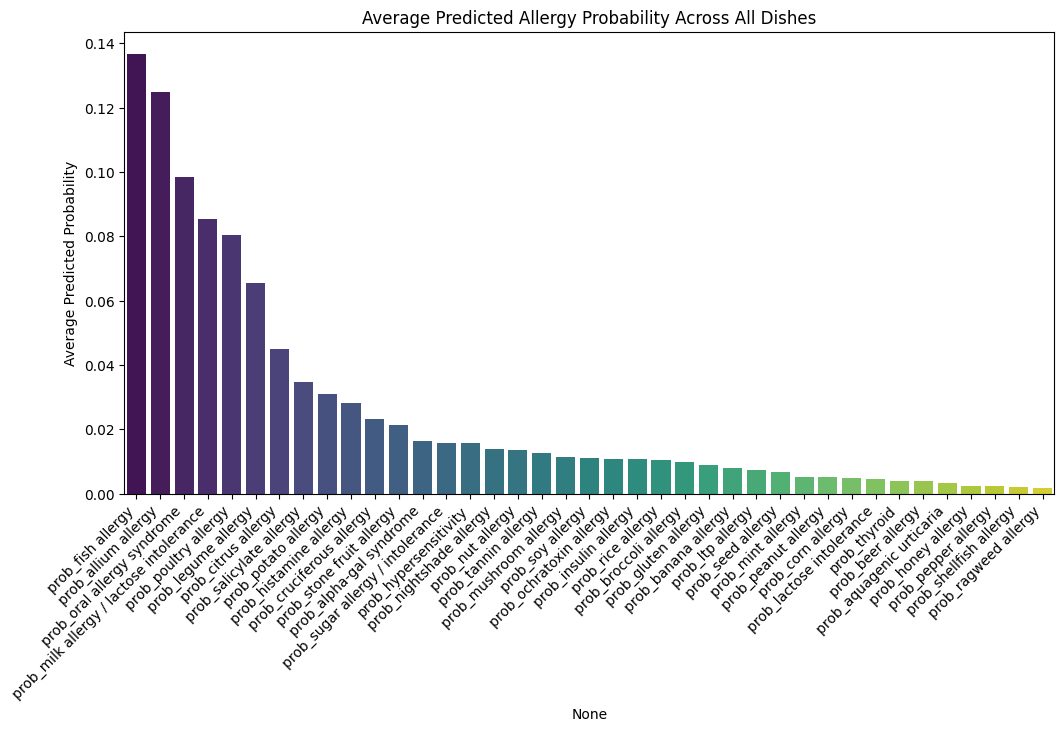

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# average predicted probability for each allergy across all dishes
# visualize the probability distribution of different allergies across all dishes
# this shows which allergies are most common or likely in the dataset
allergy_prob_means = proba_df.mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=allergy_prob_means.index, y=allergy_prob_means.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Predicted Probability")
plt.title("Average Predicted Allergy Probability Across All Dishes")
plt.show()

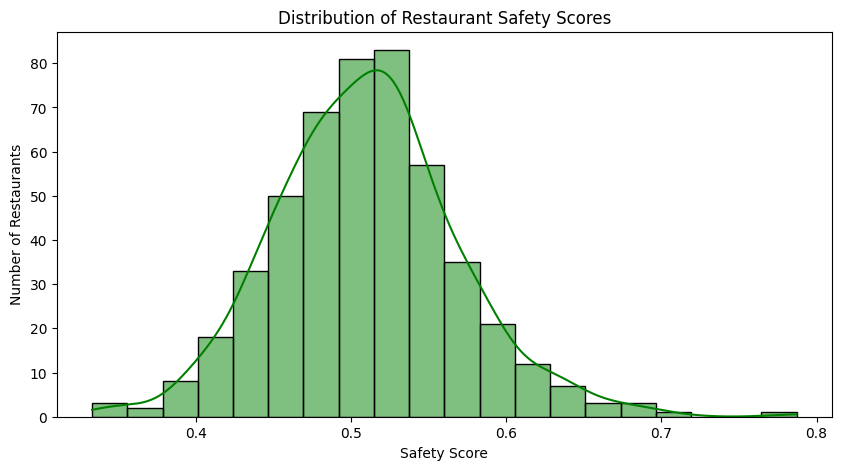

In [53]:
# plot the distribution of restaurant safety scores to see which restaurants are generally safer
# (not very helpful in the case for specific allergies)
plt.figure(figsize=(10,5))
sns.histplot(restaurantSafety['SafetyScore'], bins=20, kde=True, color='green')
plt.xlabel("Safety Score")
plt.ylabel("Number of Restaurants")
plt.title("Distribution of Restaurant Safety Scores")
plt.show()

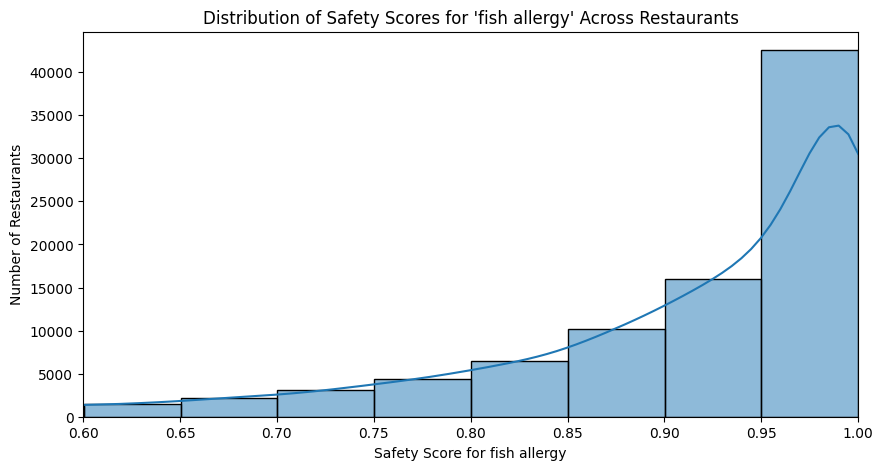

In [54]:

allergy = "fish allergy" # test and plug in different allergies here
col = f"safety_{allergy}"
plt.figure(figsize=(10,5))
plt.xlim(0.60, 1.0)
sns.histplot(restaurantDishes[col], bins=20, kde=True)
plt.xlabel(f"Safety Score for {allergy}")
plt.ylabel("Number of Restaurants")
plt.title(f"Distribution of Safety Scores for '{allergy}' Across Restaurants")
plt.show()

In [58]:
from sklearn.model_selection import train_test_split

# split allergies dataset into train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_labels, test_size=0.2, random_state=42)

# vectorize text
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# train model on training set
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    max_iter=3000,
                    alpha=0.01,
                    random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(64, 32), max_iter=3000,
              random_state=42)

In [59]:
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)

In [60]:
from sklearn.metrics import accuracy_score, classification_report

# accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.2f}")

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.45

Classification Report:
                                    precision    recall  f1-score   support

                    allium allergy       0.00      0.00      0.00         1
                alpha-gal syndrome       0.00      0.00      0.00         1
                  broccoli allergy       0.00      0.00      0.00         1
                    citrus allergy       0.25      1.00      0.40         1
                      corn allergy       1.00      1.00      1.00         1
               cruciferous allergy       0.00      0.00      0.00         1
                      fish allergy       0.00      0.00      0.00         0
                    gluten allergy       0.00      0.00      0.00         0
                 histamine allergy       0.00      0.00      0.00         1
                     honey allergy       0.00      0.00      0.00         1
                  hypersensitivity       1.00      0.50      0.67         2
                    legume allergy       0

/Users/logan/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/logan/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/logan/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/logan/myenv/lib/python3.12